<center><h1>Visual Question Answering (VQA)</h1></center>

In [1]:
#installing packages (since i'm using google colab,i'm installing from notebook itself)

%%capture
!pip3 install --upgrade tensorflow-gpu
!pip install tensorflow --upgrade

In [9]:
#importing packages
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import json
import ast

<h1>Mounting the Drive </h1>

In [2]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


<h1>Variables</h1>

In [5]:
currentDirectory = "/content/drive/My Drive/pcase_study_2/"
os.chdir(currentDirectory)
currentDirectory = ""
dataDirectory = currentDirectory + "data/"
imageDirectory = dataDirectory + "train2014/"
imageNumpyDirectory = dataDirectory + "VGG19_Numpy/"
modelsDirectory = currentDirectory + "Models/"
img_width = 448
img_height = 448

BATCH_SIZE = 64
BUFFER_SIZE = 300

In [6]:
while True:
    try:
        print(len(os.listdir(imageNumpyDirectory)))
        break
    except:
        print("Buffer Error")
        continue

82783


In [7]:
from PythonModules.vqa import VQA, images_to_numpy, get_tokenizer_labelEncoder
model = VQA()
model.load_weights(modelsDirectory  + "Coattention/best_03.hdf5")
tokenizer, label_encoder = get_tokenizer_labelEncoder()

In [10]:
#X_val = pd.read_csv(dataDirectory + 'X_val_48k.csv')
data = pd.read_csv(dataDirectory + 'data.csv')
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

In [11]:
def get_imageTensor(img, ques, qtype, answer,atype,answers):
    img_tensor = np.load(img.decode('utf-8').replace(imageDirectory,imageNumpyDirectory).replace(".jpg","") + '.npy')
    img_tensor = np.reshape(img_tensor,(-1,img_tensor.shape[-1]))
    return img_tensor, ques, qtype, answer, atype,answers

def createDataset(image_paths,question_vector,question_type,answer_vector,answer_type,answers):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, question_vector.astype(np.float32), question_type,answer_vector,answer_type,answers))

    # using map to load the numpy files in parallel
    dataset = dataset.map(lambda img, ques, qtype, answer, atype,answers : tf.numpy_function(get_imageTensor, [img, ques, qtype, answer, atype,answers], 
                                                                                     [tf.float32, tf.float32, tf.string, tf.int64, tf.string,tf.string]),
                                      num_parallel_calls = tf.data.experimental.AUTOTUNE)
    # shuffling and batching
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

    return dataset

In [12]:
image_paths_val = X_val['image_id'].apply(lambda x:  imageDirectory + 'COCO_train2014_' + '%012d.jpg' % (x)).values
answer_vector_val = label_encoder.transform(X_val['multiple_choice_answer'].apply(lambda x: x).values)
answer_vector_val = answer_vector_val.toarray()
answer_type = X_val['answer_type'].values 
answers = X_val['answers'].values 

val_question_seqs = tokenizer.texts_to_sequences(X_val['question'].values)
question_vector_val = tf.keras.preprocessing.sequence.pad_sequences(val_question_seqs,padding='post',maxlen=24)

question_type = X_val['question_type'].values 

dataset_val = createDataset(image_paths_val, question_vector_val, question_type, answer_vector_val,answer_type,answers)

In [13]:
len(X_val)/64

1386.75

In [14]:
error_dict = {  _qtype : { 'top_1' : 0,'top_2' : 0,'top_3' : 0 ,'top_5' : 0,'count' : 0 } for _qtype in np.unique(question_type) }
actual_list = []
pred_list = []

for (batch, (img_tensor, question, qtype, answer,atype,answers)) in tqdm(enumerate(dataset_val)):
    y_pred = model.predict([img_tensor,question])

    for i in range(y_pred.shape[0]):
        _qtype = qtype[i].numpy().decode('utf-8')
        _atype = atype[i].numpy().decode('utf-8')
        error_dict[_qtype]['count'] += 1 
        
        for _k in [1]:#[1,2,3,5]:
            if _atype == 'yes/no' and _k > 1:
              top_k = tf.math.top_k(y_pred, k = 1 ).indices.numpy()[i]
            else:
              top_k = tf.math.top_k(y_pred, k = _k ).indices.numpy()[i]

            pred_classes = np.zeros(y_pred.shape[1])
            pred_classes[top_k] = 1
            actual_list.append(answers[i])
            pred_list.append(pred_classes)
            if np.dot(pred_classes,answer[i]) > 0:
              error_dict[_qtype]['top_' + str(_k)] += 1

1387it [1:20:22,  3.48s/it]


In [15]:
def model_metric(predictions, truths):
  total = 0
  correct_val=0.0
  for prediction, truth in tqdm(zip(predictions, truths)):
    truth = ast.literal_eval(truth.numpy().decode('utf-8'))#json.loads(truth.numpy().decode('utf-8').replace("\'", "\""))
    prediction = label_encoder.inverse_transform(np.array([prediction]))[0]
    temp_count=0
    total +=1
    for _truth in truth:
      if prediction == _truth['answer']:
        temp_count+=1
    # accuracy = min((# humans that provided that answer/3) , 1)
    if temp_count>2:
      correct_val+=1
    else:
      correct_val+=float(temp_count)/3
  return (correct_val/total)*100

model_metric(pred_list,actual_list)

88752it [00:11, 7423.35it/s]


41.519815515894166

In [65]:

(X_val['answers'].values[7])

{'answer': "so they don't wander off",
 'answer_confidence': 'yes',
 'answer_id': 1}

# <h1>1. Error Analysis (Only with top 1 results)</h1>

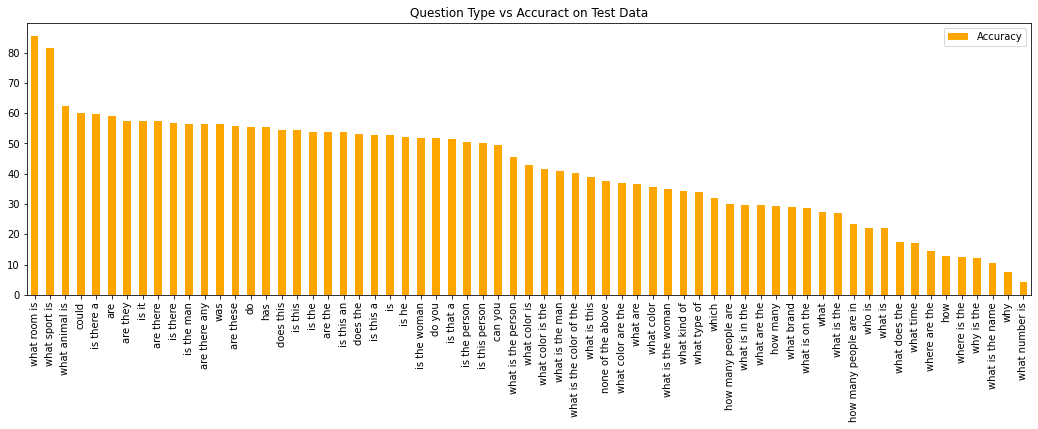

In [ ]:
df_EA  = pd.DataFrame(error_dict).T
df_EA["Question_Type"] = df_EA.index
df_EA['Accuracy'] = df_EA['top_1']/df_EA['count'] * 100

df_EA = df_EA.sort_values('Accuracy',ascending=False)

ax = df_EA[['Question_Type','Accuracy']].plot.bar(stacked=False, figsize=(18,5), color='orange')
plt.title('Question Type vs Accuract on Test Data')
plt.show()

<h2> Observations </h2>

<ul>
<li>Model is performing very well (>80% accuracy) for questions type like 'What room', 'What sport' and 'What animal'  </li>
<li> Most of the Question type 'Could', 'are', 'is', 'do you'.... will have only two possible answers yes/no. for these kind of question type acuuracy nearly 60%</li>
<li>Model is not performing very well (less than 20% accuracy) for questions type like 'What number', 'why','how' and 'where are the'</li>
</ul>

# <h1>2. Error Analysis (with top 2,3,5 results)</h1>

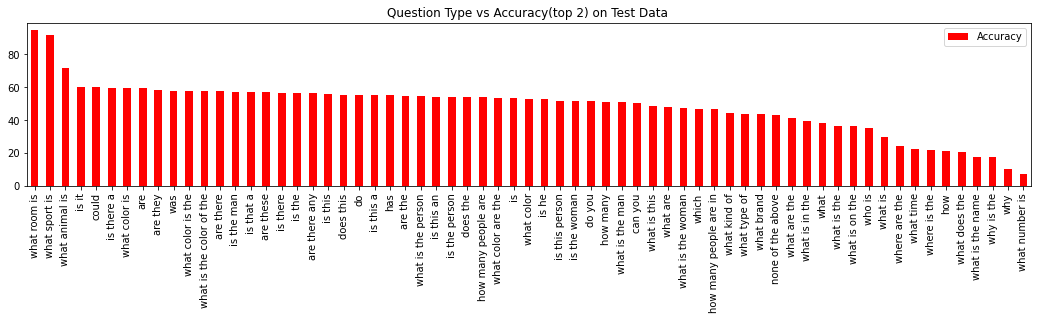

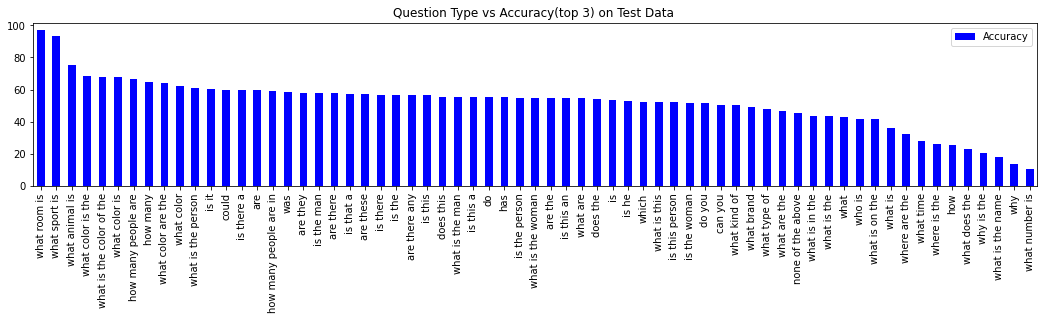

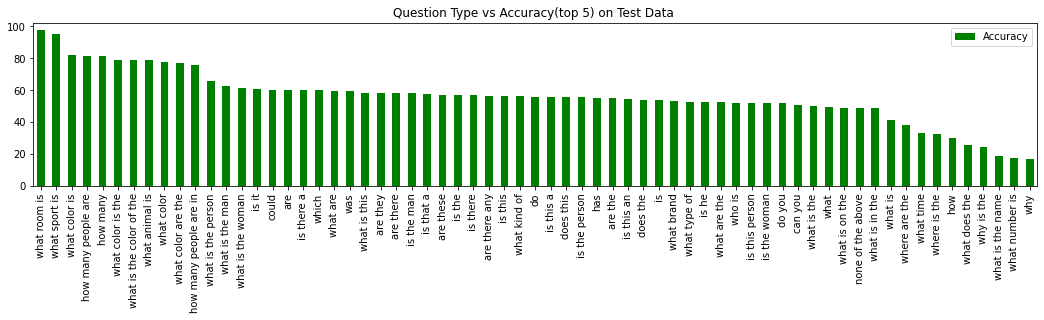

In [ ]:
c = ['r','b','g']
for idx , _k in enumerate([2,3,5]):  
  df_EA  = pd.DataFrame(error_dict).T
  df_EA["Question_Type"] = df_EA.index
  df_EA['Accuracy'] = df_EA['top_' + str(_k) ]/df_EA['count'] * 100

  df_EA = df_EA.sort_values('Accuracy',ascending=False)

  ax = df_EA[['Question_Type','Accuracy']].plot.bar(stacked=False, figsize=(18,3), color=c[idx])
  plt.title('Question Type vs Accuracy(top '+ str(_k) +') on Test Data ')
  plt.show()

<h2> Observations </h2>

<ul>
<li> If we consider more than one answer model is able to predict almost 90% times correctlty for question type like What room', 'What sport' and 'What animal' </li>
<li> Question type like 'Could', 'are', 'is', 'do you'.... will have only two possible answers yes/no. so I'm calculating only top one value for these kind of questions. that's why percentage for these same as first one.</li>

<li>Model is not performing very well even with more answers for questions type like 'What number', 'why', 'how' and 'where are the'. because these questions type has so many possible answers. </li>
</ul>